## 1. Библиотеки и преднастройки

### Стандартные библиотеки для работы с данными

In [ ]:
import os
import json
import numpy as np
import pandas as pd

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

### Библиотеки для построения графиков

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Библиотека для настройки визуала

In [ ]:
import optuna
import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats

### Дополнительные параметры

In [ ]:
# Настройка стиля для визуализации - синяя палитра
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Определяем цветовую палитру в синих тонах
blue_palette = ["#081D58", "#253494", "#225EA8", "#1D91C0", "#41B6C4", "#7FCDBB", "#C7E9B4"]
sns.set_palette(sns.color_palette(blue_palette))

## 2. Обучение

### 2.1 Метрики

In [ ]:
# Функции для метрик
def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mape(y_true, y_pred):
    mask = (y_true > 0)
    return mean_absolute_percentage_error(y_true[mask], y_pred[mask])

def rmse(y_true, y_pred):
    mask = (y_true > 0)
    return np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))

### 2.2 Построение моделей и сравнение 

In [ ]:
# Функция для оптимизации с комбинированной метрикой и контролем разрыва
def objective_with_combined_metric(trial, X_train, y_train, X_val, y_val):
    param = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'booster': 'gbtree',
            'tree_method': 'hist',
            'device': 'cuda',
            
            # Параметры с консервативными диапазонами
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 7),                              # <-- уменьшен верхний предел
            'min_child_weight': trial.suggest_int('min_child_weight', 20, 40),              # <-- увеличены значения
            'gamma': trial.suggest_float('gamma', 3.0, 10.0),                               # <-- увеличены значения
            'alpha': trial.suggest_float('alpha', 2.0, 20.0, log=True),                     # <-- увеличены значения
            'lambda': trial.suggest_float('lambda', 2.0, 20.0, log=True),                   # <-- увеличены значения
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.8),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 0.8),
            'colsample_bynode': trial.suggest_float('colsample_bynode', 0.6, 0.8),
            }
    
    # Создаем DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    # Обучаем модель
    results = {}
    model = xgb.train(
                    param,
                    dtrain,
                    num_boost_round=2000,
                    evals=[(dtrain, 'train'), (dval, 'eval')],
                    early_stopping_rounds=25,
                    evals_result=results,
                    verbose_eval=False
                    )
    
    # Получаем предсказания
    y_pred = model.predict(dval)
    
    # Вычисляем метрики
    rmse_val = rmse(y_val, y_pred)
    mae_val = mae(y_val, y_pred)
    mape_val = mape(y_val, y_pred)
    
    # Вычисляем разрыв между тренировочной и валидационной ошибками
    train_rmse = results['train']['rmse'][model.best_iteration]
    eval_rmse = results['eval']['rmse'][model.best_iteration]
    gap_ratio = eval_rmse / train_rmse
    
    # Комбинированная метрика с сильным штрафом за большой разрыв
    combined_metric = 0.5 * rmse_val + 0.3 * mae_val + 0.2 * mape_val
    
    # Прогрессивный штраф за разрыв
    if gap_ratio > 1.2:
        gap_penalty = (gap_ratio - 1.2) ** 2 * rmse_val * 0.3
        combined_metric += gap_penalty
    
    return combined_metric, model, gap_ratio

# Функция для обучения ансамбля моделей (bagging)
def train_xgboost_ensemble(X_train, y_train, X_val, y_val, params, n_models=5, seed_start=42):
    models = []
    val_scores = []
    gap_ratios = []
    all_results = []  
    
    for i in range(n_models):
        print(f"\nОбучение модели {i+1}/{n_models} в ансамбле")
        
        # Модифицируем параметры для каждой модели
        local_params = params.copy()
        local_params['seed'] = seed_start + i
        
        # Добавляем случайность через подвыборку данных (bootstrap)
        bootstrap_indices = np.random.choice(len(X_train), size=int(len(X_train) * 0.8), replace=True)
        X_bootstrap = X_train.iloc[bootstrap_indices]
        y_bootstrap = y_train.iloc[bootstrap_indices]
        
        # Создаем DMatrix
        dtrain = xgb.DMatrix(X_bootstrap, label=y_bootstrap)
        dval = xgb.DMatrix(X_val, label=y_val)
        
        # Обучаем модель
        results = {}
        model = xgb.train(
                        local_params,
                        dtrain,
                        num_boost_round=params.get('n_estimators', 2000),
                        evals=[(dtrain, 'train'), (dval, 'eval')],
                        early_stopping_rounds=25,
                        evals_result=results,
                        verbose_eval=100
                        )
        
        # Сохраняем результаты обучения
        all_results.append(results)
        
        # Вычисляем разрыв
        best_iter = model.best_iteration
        train_rmse = results['train']['rmse'][best_iter]
        eval_rmse = results['eval']['rmse'][best_iter]
        gap_ratio = eval_rmse / train_rmse
        gap_ratios.append(gap_ratio)
        
        # Оцениваем на валидационном наборе
        y_pred = model.predict(dval)
        val_rmse = rmse(y_val, y_pred)
        val_scores.append(val_rmse)
        
        models.append(model)
        print(f"Модель {i+1}: RMSE={val_rmse:.2f}, Gap={gap_ratio:.2f}, Лучшая итерация={best_iter}")
    
    # Выводим статистику по ансамблю
    print("\nСтатистика ансамбля:")
    print(f"Среднее RMSE: {np.mean(val_scores):.2f} ± {np.std(val_scores):.2f}")
    print(f"Средний Gap Ratio: {np.mean(gap_ratios):.2f} ± {np.std(gap_ratios):.2f}")
    
    # Визуализация метрик ансамбля
    plt.figure(figsize=(15, 6))
    
    # График RMSE по моделям
    plt.subplot(1, 2, 1)
    model_df = pd.DataFrame({
                            'Модель': [f"Model {i+1}" for i in range(n_models)],
                            'RMSE': val_scores
                            })
    
    sns.barplot(data=model_df, x='Модель', y='RMSE', palette='Blues_d')
    plt.axhline(y=np.mean(val_scores), color='r', linestyle='--', 
                label=f'Среднее: {np.mean(val_scores):.2f}')
    plt.title('RMSE по моделям ансамбля', fontsize=14)
    plt.ylabel('RMSE', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    
    # График разрыва по моделям
    plt.subplot(1, 2, 2)
    gap_df = pd.DataFrame({
                        'Модель': [f"Model {i+1}" for i in range(n_models)],
                        'Разрыв (Val/Train)': gap_ratios
                        })
    
    sns.barplot(data=gap_df, x='Модель', y='Разрыв (Val/Train)', palette='Blues_d')
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7)
    plt.axhline(y=np.mean(gap_ratios), color='g', linestyle='-', alpha=0.7, 
                label=f'Средний разрыв: {np.mean(gap_ratios):.2f}')
    plt.title('Разрыв между тренировочной и валидационной ошибками', fontsize=14)
    plt.ylabel('Соотношение ошибок (Val/Train)', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Визуализация кривых обучения для каждой модели ансамбля
    plt.figure(figsize=(15, 10))
    
    for i, results in enumerate(all_results):
        if i < 6:  
            plt.subplot(3, 2, i+1)
            
            # Извлекаем данные
            train_rmse = results['train']['rmse']
            eval_rmse = results['eval']['rmse']
            iterations = range(1, len(train_rmse) + 1)
            
            # Находим лучшую итерацию
            best_iter = models[i].best_iteration
            
            # Создаем DataFrame для Seaborn
            df = pd.DataFrame({
                            'Итерация': list(iterations) + list(iterations),
                            'RMSE': train_rmse + eval_rmse,
                            'Набор данных': ['Обучающий'] * len(train_rmse) + ['Валидационный'] * len(eval_rmse)
                            })
            
            # Строим график с Seaborn
            sns.lineplot(
                        data=df, 
                        x='Итерация', 
                        y='RMSE', 
                        hue='Набор данных',
                        palette=['#1D91C0', '#081D58'],
                        linewidth=2
                        )
            
            # Добавляем вертикальную линию для лучшей итерации
            plt.axvline(x=best_iter, color='#C7E9B4', linestyle='--')
            
            plt.title(f'Модель {i+1}: RMSE={val_scores[i]:.2f}, Gap={gap_ratios[i]:.2f}', fontsize=12)
            plt.xlabel('Итерация')
            plt.ylabel('RMSE')
            
            if i == 0:
                plt.legend(title='')
            else:
                plt.legend([])
    
    plt.tight_layout()
    plt.show()
    
    return models, val_scores, gap_ratios, all_results

# Функция для предсказания с помощью ансамбля
def predict_with_ensemble(models, X):
    dmatrix = xgb.DMatrix(X)
    predictions = [model.predict(dmatrix) for model in models]
    
    # Усредняем предсказания
    ensemble_prediction = np.mean(predictions, axis=0)
    
    # Вычисляем стандартное отклонение предсказаний (для оценки неопределенности)
    prediction_std = np.std(predictions, axis=0)
    
    return ensemble_prediction, prediction_std

### 2.3 Построение графиков

In [ ]:
# Визуализация кривых обучения
def plot_learning_curves(results, title='Кривые обучения'):
    plt.figure(figsize=(12, 8))
    
    # Извлекаем данные
    train_rmse = results['train']['rmse']
    eval_rmse = results['eval']['rmse']
    iterations = range(1, len(train_rmse) + 1)
    
    # Находим лучшую итерацию
    best_iteration = np.argmin(eval_rmse) + 1
    
    # Создаем DataFrame для Seaborn
    df = pd.DataFrame({
                    'Итерация': list(iterations) + list(iterations),
                    'RMSE': train_rmse + eval_rmse,
                    'Набор данных': ['Обучающий'] * len(train_rmse) + ['Валидационный'] * len(eval_rmse)
                    })
    
    # Строим график с Seaborn
    ax = sns.lineplot(
                    data=df, 
                    x='Итерация', 
                    y='RMSE', 
                    hue='Набор данных',
                    palette=['#1D91C0', '#081D58'],
                    linewidth=2.5
                    )
    
    # Добавляем вертикальную линию для лучшей итерации
    plt.axvline(x=best_iteration, color='#C7E9B4', linestyle='--', label=f'Лучшая итерация: {best_iteration}')
    
    # Добавляем область переобучения
    if best_iteration < len(train_rmse):
        plt.axvspan(best_iteration, len(train_rmse), alpha=0.2, color='#FF9999', label='Зона переобучения')
    
    # Вычисляем разрыв на лучшей итерации
    best_train_rmse = train_rmse[best_iteration-1]
    best_eval_rmse = eval_rmse[best_iteration-1]
    gap_ratio = best_eval_rmse / best_train_rmse
    
    # Добавляем информацию о разрыве
    plt.text(0.02, 0.05, 
            f'Разрыв на лучшей итерации: {gap_ratio:.2f}x\n'
            f'Train RMSE: {best_train_rmse:.2f}\n'
            f'Eval RMSE: {best_eval_rmse:.2f}',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    plt.title(title, fontsize=16)
    plt.xlabel('Число деревьев (итераций)', fontsize=14)
    plt.ylabel('RMSE', fontsize=14)
    plt.legend(title='', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Добавляем аннотацию о переобучении
    if gap_ratio > 1.3:
        overfitting_status = 'Значительное переобучение'
        color = "red"
    elif gap_ratio > 1.1:
        overfitting_status = 'Умеренное переобучение'
        color = "orange"
    else:
        overfitting_status = 'Переобучение минимально'
        color = "green"
    
    plt.figtext(0.5, 0.01, f"Статус модели: {overfitting_status}", 
                                ha="center", fontsize=14, color=color, 
                                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    plt.tight_layout()
    plt.show()
    
    # Возвращаем информацию о переобучении
    return {
            'best_iteration': best_iteration,
            'gap_ratio': gap_ratio,
            'overfitting_status': overfitting_status
            }

# Визуализация зависимости ошибки от сложности модели
def plot_complexity_vs_error(X_train, y_train, X_val, y_val, base_params):

    max_depths = range(1, 11)
    train_scores = []
    val_scores = []
    gap_ratios = []
    
    # Создаем DMatrix один раз
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    for depth in max_depths:
        # Копируем базовые параметры и меняем глубину
        params = base_params.copy()
        params['max_depth'] = depth
        
        # Обучаем модель
        results = {}
        model = xgb.train(
                        params,
                        dtrain,
                        num_boost_round=100,  # Ограничиваем для скорости
                        evals=[(dtrain, 'train'), (dval, 'eval')],
                        evals_result=results,
                        verbose_eval=False
                        )
        
        # Получаем ошибки на последней итерации
        train_rmse = results['train']['rmse'][-1]
        val_rmse = results['eval']['rmse'][-1]
        
        train_scores.append(train_rmse)
        val_scores.append(val_rmse)
        gap_ratios.append(val_rmse / train_rmse)
    
    # Создаем DataFrame для визуализации
    df = pd.DataFrame({
                        'Глубина дерева': list(max_depths) + list(max_depths),
                        'RMSE': train_scores + val_scores,
                        'Набор данных': ['Обучающий'] * len(max_depths) + ['Валидационный'] * len(max_depths)
                        })
    
    # Находим оптимальную глубину
    optimal_depth = max_depths[np.argmin(val_scores)]
    
    # Визуализация
    plt.figure(figsize=(12, 8))
    
    # Основной график
    ax = sns.lineplot(
                    data=df, 
                    x='Глубина дерева', 
                    y='RMSE', 
                    hue='Набор данных',
                    palette=['#1D91C0', '#081D58'],
                    linewidth=2.5,
                    marker='o',
                    markersize=8
                    )
    
    # Добавляем вертикальную линию для оптимальной глубины
    plt.axvline(x=optimal_depth, color='#C7E9B4', linestyle='--', 
                label=f'Оптимальная глубина: {optimal_depth}')
    
    # Добавляем области недообучения и переобучения
    plt.axvspan(1, optimal_depth, alpha=0.2, color='#FFCC99', label='Зона недообучения')
    plt.axvspan(optimal_depth, max(max_depths), alpha=0.2, color='#FF9999', label='Зона переобучения')
    
    # Добавляем информацию о разрывах
    gap_df = pd.DataFrame({
                            'Глубина дерева': max_depths,
                            'Разрыв (Val/Train)': gap_ratios
                            })
    
    # Добавляем второй y-axis для разрыва
    ax2 = ax.twinx()
    sns.lineplot(
                data=gap_df, 
                x='Глубина дерева', 
                y='Разрыв (Val/Train)',
                color='#7FCDBB',
                linewidth=2,
                marker='s',
                markersize=6,
                ax=ax2
                )
    
    # Настройка графика
    ax.set_title('Зависимость ошибки от сложности модели (глубины дерева)', fontsize=16)
    ax.set_xlabel('Максимальная глубина дерева', fontsize=14)
    ax.set_ylabel('RMSE', fontsize=14)
    ax2.set_ylabel('Разрыв (Val/Train)', fontsize=14, color='#7FCDBB')
    ax2.tick_params(axis='y', colors='#7FCDBB')
    
    # Настройка легенды
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles=handles1 + handles2, labels=labels1 + ['Разрыв (Val/Train)'], loc='lower right', fontsize=12)
    
    # Добавляем аннотацию с выводом
    min_gap = min(gap_ratios)
    max_gap = max(gap_ratios)
    
    plt.figtext(0.5, 0.01, 
                f"Минимальный разрыв: {min_gap:.2f}x при глубине {max_depths[np.argmin(gap_ratios)]}\n"
                f"Максимальный разрыв: {max_gap:.2f}x при глубине {max_depths[np.argmax(gap_ratios)]}",
                ha="center", fontsize=12, 
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return {
            'optimal_depth': optimal_depth,
            'min_gap': min_gap,
            'max_gap': max_gap,
            'depths': list(max_depths),
            'train_scores': train_scores,
            'val_scores': val_scores,
            'gap_ratios': gap_ratios
            }

# Функция для кросс-валидации с контролем разрыва
def xgb_cv_with_gap_control(params, X_train, y_train, nfold=5):
    # Создаем KFold для разделения данных
    kf = KFold(n_splits=nfold, shuffle=True, random_state=42)
    
    # Отслеживаем метрики по фолдам
    fold_metrics = []
    gap_ratios = []
    best_iterations = []
    all_results = [] 
    
    # Для каждого фолда
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"Обучение на фолде {fold+1}/{nfold}")
        
        # Разделяем данные
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Создаем DMatrix
        dtrain = xgb.DMatrix(X_fold_train, label=y_fold_train)
        dval = xgb.DMatrix(X_fold_val, label=y_fold_val)
        
        # Обучаем модель
        results = {}
        model = xgb.train(
                        params,
                        dtrain,
                        num_boost_round=2000,
                        evals=[(dtrain, 'train'), (dval, 'eval')],
                        early_stopping_rounds=25,
                        evals_result=results,
                        verbose_eval=100
                        )
        
        # Сохраняем результаты обучения
        all_results.append(results)
        
        # Сохраняем лучшую итерацию
        best_iterations.append(model.best_iteration)
        
        # Получаем метрики
        train_rmse = results['train']['rmse'][model.best_iteration]
        eval_rmse = results['eval']['rmse'][model.best_iteration]
        gap_ratio = eval_rmse / train_rmse
        gap_ratios.append(gap_ratio)
        
        # Получаем предсказания
        y_pred = model.predict(dval)
        
        # Вычисляем метрики
        metrics = {
                'RMSE': rmse(y_fold_val, y_pred),
                'MAE': mae(y_fold_val, y_pred),
                'MAPE': mape(y_fold_val, y_pred),
                'Gap_Ratio': gap_ratio
                }
        
        fold_metrics.append(metrics)
        print(f"Фолд {fold+1} метрики: {metrics}")
        
    # Вычисляем средние метрики
    avg_metrics = {
                    'RMSE': np.mean([m['RMSE'] for m in fold_metrics]),
                    'MAE': np.mean([m['MAE'] for m in fold_metrics]),
                    'MAPE': np.mean([m['MAPE'] for m in fold_metrics]),
                    'Gap_Ratio': np.mean(gap_ratios)
                    }
    
    # Определяем оптимальное число итераций (медиана)
    optimal_iterations = int(np.median(best_iterations))
    
    print(f"\nСредние метрики по {nfold} фолдам:")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print(f"Оптимальное число итераций: {optimal_iterations}")
    
    # Визуализация результатов
    plt.figure(figsize=(15, 8))
    
    # График метрик по фолдам
    plt.subplot(1, 2, 1)
    metrics_df = pd.DataFrame(fold_metrics)
    metrics_df.index = [f"Fold {i+1}" for i in range(len(metrics_df))]
    
    # Используем Seaborn для более красивого графика
    sns.barplot(data=metrics_df.reset_index().melt(id_vars='index', value_vars=['RMSE', 'MAE']), 
                x='index', y='value', hue='variable', palette=['#1D91C0', '#081D58'])
    plt.title('Метрики по фолдам', fontsize=14)
    plt.ylabel('Значение', fontsize=12)
    plt.xlabel('Фолд', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(title='Метрика')
    
    # График разрыва по фолдам
    plt.subplot(1, 2, 2)
    gap_df = pd.DataFrame({
                            'Фолд': [f"Fold {i+1}" for i in range(len(gap_ratios))],
                            'Разрыв (Val/Train)': gap_ratios
                            })
    
    sns.barplot(data=gap_df, x='Фолд', y='Разрыв (Val/Train)', palette='Blues_d')
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7)
    plt.axhline(y=np.mean(gap_ratios), color='g', linestyle='-', alpha=0.7, 
                label=f'Средний разрыв: {np.mean(gap_ratios):.2f}')
    plt.title('Разрыв между тренировочной и валидационной ошибками', fontsize=14)
    plt.ylabel('Соотношение ошибок (Val/Train)', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Визуализация кривых обучения для каждого фолда
    plt.figure(figsize=(15, 10))
    
    for i, results in enumerate(all_results):
        plt.subplot(3, 2, i+1)
        
        # Извлекаем данные
        train_rmse = results['train']['rmse']
        eval_rmse = results['eval']['rmse']
        iterations = range(1, len(train_rmse) + 1)
        
        # Находим лучшую итерацию
        best_iter = best_iterations[i]
        
        # Создаем DataFrame для Seaborn
        df = pd.DataFrame({
                        'Итерация': list(iterations) + list(iterations),
                        'RMSE': train_rmse + eval_rmse,
                        'Набор данных': ['Обучающий'] * len(train_rmse) + ['Валидационный'] * len(eval_rmse)
                        })
        
        # Строим график с Seaborn
        sns.lineplot(
                    data=df, 
                    x='Итерация', 
                    y='RMSE', 
                    hue='Набор данных',
                    palette=['#1D91C0', '#081D58'],
                    linewidth=2
                    )
        
        # Добавляем вертикальную линию для лучшей итерации
        plt.axvline(x=best_iter, color='#C7E9B4', linestyle='--')
        
        # Вычисляем разрыв на лучшей итерации
        best_train_rmse = train_rmse[best_iter-1]
        best_eval_rmse = eval_rmse[best_iter-1]
        gap = gap_ratios[i]
        
        plt.title(f'Фолд {i+1}: Gap={gap:.2f}x, Best Iter={best_iter}', fontsize=12)
        plt.xlabel('Итерация')
        plt.ylabel('RMSE')
        
        if i == 0:
            plt.legend(title='')
            
        else:
            plt.legend([])
    
    plt.tight_layout()
    plt.show()
    
    return avg_metrics, optimal_iterations, gap_ratios, all_results

# Функция для анализа остатков
def analyze_residuals(y_true, y_pred, title="Анализ остатков"):
    """
    Анализирует остатки модели для выявления паттернов
    """
    # Вычисляем остатки
    residuals = y_true - y_pred
    
    # Создаем DataFrame для анализа
    residual_df = pd.DataFrame({
                                'Actual': y_true,
                                'Predicted': y_pred,
                                'Residual': residuals
                                })
    
    # Визуализация остатков
    plt.figure(figsize=(16, 12))
    
    # 1. Распределение остатков
    plt.subplot(2, 2, 1)
    sns.histplot(residuals, kde=True, color='#1D91C0')
    plt.title('Распределение остатков', fontsize=14)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.grid(True, alpha=0.3)
    
    # 2. Остатки vs Предсказанные значения
    plt.subplot(2, 2, 2)
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, color='#081D58')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Остатки vs Предсказанные значения', fontsize=14)
    plt.xlabel('Предсказанные значения', fontsize=12)
    plt.ylabel('Остатки', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Добавляем линию тренда для проверки систематической ошибки
    z = np.polyfit(y_pred, residuals, 1)
    p = np.poly1d(z)
    plt.plot(np.sort(y_pred), p(np.sort(y_pred)), "r--", linewidth=2)
    
    # 3. QQ-plot
    plt.subplot(2, 2, 3)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('QQ-Plot остатков', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # 4. Абсолютные остатки vs Предсказанные значения (для проверки гетероскедастичности)
    plt.subplot(2, 2, 4)
    sns.scatterplot(x=y_pred, y=np.abs(residuals), alpha=0.5, color='#225EA8')
    plt.title('Абсолютные остатки vs Предсказанные значения', fontsize=14)
    plt.xlabel('Предсказанные значения', fontsize=12)
    plt.ylabel('Абсолютные остатки', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Добавляем линию тренда для проверки гетероскедастичности
    z = np.polyfit(y_pred, np.abs(residuals), 1)
    p = np.poly1d(z)
    plt.plot(np.sort(y_pred), p(np.sort(y_pred)), "r--", linewidth=2)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    # Вычисляем статистики остатков
    stats_dict = {
                'Mean Residual': np.mean(residuals),
                'Std Residual': np.std(residuals),
                'Min Residual': np.min(residuals),
                'Max Residual': np.max(residuals),
                'Median Residual': np.median(residuals),
                'Skewness': stats.skew(residuals),
                'Kurtosis': stats.kurtosis(residuals)
                }
    
    print('Статистики остатков:')
    for key, value in stats_dict.items():
        print(f"{key}: {value:.4f}")
    
    # Тест на нормальность
    shapiro_test = stats.shapiro(residuals[:5000])
    print(f"\nТест Шапиро-Уилка на нормальность: p-value = {shapiro_test.pvalue:.6f}")
    if shapiro_test.pvalue < 0.05:
        print("Остатки НЕ распределены нормально (p < 0.05)")
    else:
        print("Остатки распределены нормально (p >= 0.05)")
    
    return residual_df, stats_dict

# Функция для визуализации важности признаков
def plot_feature_importance(models, feature_names, top_n=20):
    
    # Получаем важность признаков из каждой модели
    importance_dfs = []
    
    for i, model in enumerate(models):
        
        # Получаем важность признаков
        importance = model.get_score(importance_type='gain')
        
        # Преобразуем в DataFrame
        df = pd.DataFrame({
                        'Feature': list(importance.keys()),
                        f'Model_{i+1}': list(importance.values())
                        })
        
        importance_dfs.append(df)
    
    # Объединяем все DataFrame
    if len(importance_dfs) > 1:
        merged_df = importance_dfs[0]
        for df in importance_dfs[1:]:
            merged_df = pd.merge(merged_df, df, on='Feature', how='outer')
    else:
        merged_df = importance_dfs[0]
    
    # Заполняем NaN нулями
    merged_df = merged_df.fillna(0)
    
    # Вычисляем среднюю важность и стандартное отклонение
    model_cols = [col for col in merged_df.columns if col.startswith('Model_')]
    merged_df['Mean_Importance'] = merged_df[model_cols].mean(axis=1)
    merged_df['Std_Importance'] = merged_df[model_cols].std(axis=1)
    merged_df['CV_Importance'] = merged_df['Std_Importance'] / (merged_df['Mean_Importance'] + 1e-10)  # Избегаем деления на ноль
    
    # Сортируем по средней важности
    merged_df = merged_df.sort_values('Mean_Importance', ascending=False).reset_index(drop=True)
    
    # Выбираем топ-N признаков
    top_features = merged_df.head(top_n)
    
    # Визуализируем
    plt.figure(figsize=(12, 10))
    
    # Строим barplot без использования xerr (вместо этого добавим вручную)
    ax = sns.barplot(x='Mean_Importance', y='Feature', data=top_features, palette='Blues_d')
    
    # Добавляем полосы ошибок вручную
    for i, (_, row) in enumerate(top_features.iterrows()):
        ax.errorbar(
                    x=row['Mean_Importance'], 
                    y=i, 
                    xerr=row['Std_Importance'],
                    fmt='none', 
                    ecolor='black', 
                    capsize=3
                    )
    
    # Добавляем значения на график
    for i, v in enumerate(top_features['Mean_Importance']):
        ax.text(v + 0.1, i, f"{v:.2f} ± {top_features['Std_Importance'].iloc[i]:.2f}", va='center', fontsize=9)
    
    plt.title('Топ признаков по важности (средняя по ансамблю)', fontsize=14)
    plt.xlabel('Важность (gain)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Создаем тепловую карту для стабильности признаков
    stability_df = top_features[['Feature', 'Mean_Importance', 'CV_Importance']].head(15)
    
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(stability_df.set_index('Feature')[['Mean_Importance', 'CV_Importance']], 
                    annot=True, cmap='Blues', fmt='.2f')
    plt.title('Стабильность важности признаков в ансамбле', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return merged_df

# Функция для визуализации неопределенности предсказаний
def visualize_prediction_uncertainty(y_test, ensemble_pred, pred_std):
    plt.figure(figsize=(12, 8))
    
    # Преобразуем в numpy массивы для безопасности
    y_test_array = np.array(y_test)
    
    # Создаем индексы и сортируем для лучшей визуализации
    indices = np.arange(len(y_test_array))
    sorted_indices = np.argsort(y_test_array)
    
    sorted_y_test = y_test_array[sorted_indices]
    sorted_pred = ensemble_pred[sorted_indices]
    sorted_std = pred_std[sorted_indices]
    
    # Ограничиваем количество точек для ясности визуализации
    max_points = 100
    if len(sorted_indices) > max_points:
        step = len(sorted_indices) // max_points
        display_indices = np.arange(0, len(sorted_indices), step)
        sorted_y_test = sorted_y_test[display_indices]
        sorted_pred = sorted_pred[display_indices]
        sorted_std = sorted_std[display_indices]
        plot_indices = np.arange(len(display_indices))
    else:
        plot_indices = np.arange(len(sorted_indices))
    
    # Создаем DataFrame для Seaborn
    uncertainty_df = pd.DataFrame({
                                'Индекс': plot_indices,
                                'Фактическое значение': sorted_y_test,
                                'Предсказание': sorted_pred,
                                'Стандартное отклонение': sorted_std
                                })
    
    # График предсказаний с интервалами
    plt.fill_between(
                    plot_indices, 
                    sorted_pred - 1.96 * sorted_std, 
                    sorted_pred + 1.96 * sorted_std, 
                    alpha=0.3, 
                    color='#1D91C0', 
                    label='95% доверительный интервал'
                    )
    
    sns.lineplot(x='Индекс', y='Предсказание', data=uncertainty_df, 
                 color='#081D58', linewidth=2, label='Предсказание')
    sns.lineplot(x='Индекс', y='Фактическое значение', data=uncertainty_df, 
                 color='#C7E9B4', linewidth=2, label='Фактическое значение')
    
    plt.xlabel('Индекс образца (отсортированный)', fontsize=12)
    plt.ylabel('Значение', fontsize=12)
    plt.title('Предсказания ансамбля с 95% доверительными интервалами', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Визуализация распределения неопределенности
    plt.figure(figsize=(10, 6))
    sns.histplot(pred_std, kde=True, color='#1D91C0')
    plt.axvline(np.mean(pred_std), color='r', linestyle='--', label=f'Среднее: {np.mean(pred_std):.2f}')
    plt.axvline(np.median(pred_std), color='g', linestyle='--', label=f'Медиана: {np.median(pred_std):.2f}')
    plt.title('Распределение стандартных отклонений предсказаний', fontsize=14)
    plt.xlabel('Стандартное отклонение', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Визуализация зависимости неопределенности от значения
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test_array, y=pred_std, alpha=0.5, color='#225EA8')
    
    # Добавляем линию тренда
    z = np.polyfit(y_test_array, pred_std, 1)
    p = np.poly1d(z)
    plt.plot(np.sort(y_test_array), p(np.sort(y_test_array)), "r--", linewidth=2)
    
    plt.xlabel('Фактическое значение', fontsize=12)
    plt.ylabel('Стандартное отклонение предсказания', fontsize=12)
    plt.title('Зависимость неопределенности от фактического значения', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Сравнение моделей разной сложности для оценки переобучения
def compare_model_complexity(X_train, y_train, X_val, y_val, X_test, y_test, base_params):

    # Определяем разные уровни сложности
    complexity_levels = [
                        {'max_depth': 3, 'min_child_weight': 30, 'n_estimators': 100, 'name': 'Простая'},
                        {'max_depth': 5, 'min_child_weight': 20, 'n_estimators': 500, 'name': 'Средняя'},
                        {'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 1000, 'name': 'Сложная'},
                        {'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 2000, 'name': 'Очень сложная'}
                        ]
    
    # Метрики для каждой модели
    train_metrics = []
    val_metrics = []
    test_metrics = []
    gap_ratios = []
    
    # Обучаем модели разной сложности
    for complexity in complexity_levels:
        print(f"\nОбучение {complexity['name']} модели...")
        
        # Копируем базовые параметры и обновляем их
        params = base_params.copy()
        params.update({
                    'max_depth': complexity['max_depth'],
                    'min_child_weight': complexity['min_child_weight']
                    })
        
        # Создаем DMatrix
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        # Обучаем модель
        results = {}
        model = xgb.train(
                        params,
                        dtrain,
                        num_boost_round=complexity['n_estimators'],
                        evals=[(dtrain, 'train'), (dval, 'eval')],
                        early_stopping_rounds=25,
                        evals_result=results,
                        verbose_eval=100
                        )
        
        # Получаем предсказания
        y_train_pred = model.predict(dtrain)
        y_val_pred = model.predict(dval)
        y_test_pred = model.predict(dtest)
        
        # Вычисляем метрики
        train_rmse = rmse(y_train, y_train_pred)
        val_rmse = rmse(y_val, y_val_pred)
        test_rmse = rmse(y_test, y_test_pred)
        
        # Вычисляем разрыв
        gap_ratio = val_rmse / train_rmse
        
        # Сохраняем метрики
        train_metrics.append(train_rmse)
        val_metrics.append(val_rmse)
        test_metrics.append(test_rmse)
        gap_ratios.append(gap_ratio)
        
        print(f"{complexity['name']} модель: Train RMSE={train_rmse:.2f}, Val RMSE={val_rmse:.2f}, "
              f"Test RMSE={test_rmse:.2f}, Gap={gap_ratio:.2f}")
    
    # Создаем DataFrame для визуализации
    complexity_df = pd.DataFrame({
                                'Модель': [c['name'] for c in complexity_levels],
                                'Train RMSE': train_metrics,
                                'Val RMSE': val_metrics,
                                'Test RMSE': test_metrics,
                                'Gap Ratio': gap_ratios,
                                'Max Depth': [c['max_depth'] for c in complexity_levels],
                                'Min Child Weight': [c['min_child_weight'] for c in complexity_levels],
                                'N Estimators': [c['n_estimators'] for c in complexity_levels]
                                })
    
    # Визуализация метрик по сложности
    plt.figure(figsize=(14, 10))
    
    # График RMSE по сложности
    plt.subplot(2, 1, 1)
    
    # Создаем DataFrame в длинном формате для Seaborn
    metrics_df = pd.melt(
                        complexity_df, 
                        id_vars=['Модель'], 
                        value_vars=['Train RMSE', 'Val RMSE', 'Test RMSE'],
                        var_name='Метрика', 
                        value_name='RMSE'
                        )
    
    sns.lineplot(
                data=metrics_df, 
                x='Модель', 
                y='RMSE', 
                hue='Метрика',
                palette=['#1D91C0', '#081D58', '#7FCDBB'],
                marker='o',
                markersize=10,
                linewidth=2.5
                )
    
    plt.title('Зависимость RMSE от сложности модели', fontsize=14)
    plt.ylabel('RMSE', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title='')
    
    # График разрыва по сложности
    plt.subplot(2, 1, 2)
    
    sns.barplot(
                data=complexity_df, 
                x='Модель', 
                y='Gap Ratio',
                palette='Blues_d'
                )
    
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Идеальный разрыв (1.0)')
    plt.title('Разрыв между тренировочной и валидационной ошибками', fontsize=14)
    plt.ylabel('Соотношение ошибок (Val/Train)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Добавляем аннотации с точными значениями
    for i, gap in enumerate(gap_ratios):
        plt.text(i, gap + 0.05, f"{gap:.2f}", ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Определяем оптимальную модель по валидационной ошибке
    best_idx = np.argmin(val_metrics)
    print(f"\nОптимальная модель по валидационной ошибке: {complexity_levels[best_idx]['name']}")
    print(f"Параметры: max_depth={complexity_levels[best_idx]['max_depth']}, "
          f"min_child_weight={complexity_levels[best_idx]['min_child_weight']}, "
          f"n_estimators={complexity_levels[best_idx]['n_estimators']}")
    print(f"Метрики: Train RMSE={train_metrics[best_idx]:.2f}, Val RMSE={val_metrics[best_idx]:.2f}, "
          f"Test RMSE={test_metrics[best_idx]:.2f}, Gap={gap_ratios[best_idx]:.2f}")
    
    return complexity_df

### 2.4 Запуск обучения

In [ ]:
# Основная функция для запуска оптимизации и обучения
def run_optimized_xgboost_ensemble(X, y, n_trials=20, n_models=5):
    
    print("Начало процесса оптимизации XGBoost с ансамблевым подходом\n")
    
    # 1. Разделение данных на обучающую, валидационную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    print(f"Размеры выборок:")
    print(f"Обучающая: {X_train.shape} ({X_train.shape[0]} образцов)")
    print(f"Валидационная: {X_val.shape} ({X_val.shape[0]} образцов)")
    print(f"Тестовая: {X_test.shape} ({X_test.shape[0]} образцов)")
    
    # 2. Оптимизация гиперпараметров с учетом комбинированной метрики
    print("\nЗапуск оптимизации гиперпараметров с Optuna...")
    study = optuna.create_study(direction='minimize')
    
    def objective(trial):
        score, _, _ = objective_with_combined_metric(trial, X_train, y_train, X_val, y_val)
        return score
    
    study.optimize(objective, n_trials=n_trials)
    
    best_params = study.best_params
    print(f"\nЛучшие параметры: {best_params}")
    
    # Добавляем фиксированные параметры
    best_params.update({
                        'objective': 'reg:squarederror',
                        'eval_metric': 'rmse',
                        'booster': 'gbtree',
                        'tree_method': 'hist',
                        'device': 'cuda'
                        })
    
    # Сравнение моделей разной сложности
    print("\nСравнение моделей разной сложности для анализа переобучения...")
    complexity_comparison = compare_model_complexity(X_train, y_train, X_val, y_val, X_test, y_test, best_params)
    
    # 3. Проводим кросс-валидацию для определения оптимального числа итераций
    print("\nЗапуск кросс-валидации для определения оптимального числа итераций...")
    avg_metrics, optimal_iterations, gap_ratios, cv_results = xgb_cv_with_gap_control(best_params, X_train, y_train, nfold=5)
    
    # Добавляем лучшее число итераций в параметры
    best_params['n_estimators'] = optimal_iterations
    
    # 4. Обучаем модель на всех данных для визуализации кривых обучения
    print("\nОбучение модели на всех данных для анализа кривых обучения...")
    dtrain_full = xgb.DMatrix(X_train, label=y_train)
    dval_full = xgb.DMatrix(X_val, label=y_val)
    
    full_results = {}
    full_model = xgb.train(
                            best_params,
                            dtrain_full,
                            num_boost_round=2000,
                            evals=[(dtrain_full, 'train'), (dval_full, 'eval')],
                            early_stopping_rounds=25,
                            evals_result=full_results,
                            verbose_eval=100
                            )
    
    # Визуализация кривых обучения
    overfitting_info = plot_learning_curves(full_results, "Кривые обучения оптимизированной модели")
    
    # 5. Обучаем ансамбль моделей
    print("\nОбучение ансамбля моделей...")
    ensemble_models, val_scores, model_gaps, ensemble_results = train_xgboost_ensemble(X_train, y_train, X_val, y_val, best_params, n_models=n_models)
    
    # 6. Оцениваем ансамбль на тестовом набореф
    print("\nОценка ансамбля на тестовом наборе...")
    ensemble_pred, pred_std = predict_with_ensemble(ensemble_models, X_test)

# Функция для сохранения результатов
def save_results(results, filename='xgboost_ensemble_results.json'):
    
    # Преобразуем все numpy типы в обычные Python типы для JSON
    def convert_to_serializable(obj):
        if isinstance(obj, (np.int64, np.int32, np.int16, np.int8)):
            return int(obj)
        elif isinstance(obj, (np.float64, np.float32, np.float16)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: convert_to_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_to_serializable(item) for item in obj]
        else:
            return obj
    
    serializable_results = convert_to_serializable(results)
    
    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=4)
    
    print(f"Результаты сохранены в {filename}")

Начало процесса оптимизации XGBoost с ансамблевым подходом



[I 2025-06-16 05:26:15,747] A new study created in memory with name: no-name-3214f69b-4ae0-4ff7-8818-454f415e759e


Размеры выборок:
Обучающая: (570072, 140) (570072 образцов)
Валидационная: (190025, 140) (190025 образцов)
Тестовая: (190025, 140) (190025 образцов)

Запуск оптимизации гиперпараметров с Optuna...


[I 2025-06-16 05:26:34,491] Trial 0 finished with value: 16264.520134989294 and parameters: {'learning_rate': 0.07450669864634561, 'max_depth': 6, 'min_child_weight': 27, 'gamma': 6.565960445325878, 'alpha': 19.795090905749912, 'lambda': 6.850383135741101, 'subsample': 0.7758649756847454, 'colsample_bytree': 0.6297177815269118, 'colsample_bylevel': 0.7038609504961542, 'colsample_bynode': 0.7710366882189335}. Best is trial 0 with value: 16264.520134989294.
[I 2025-06-16 05:26:55,835] Trial 1 finished with value: 18802.657852237207 and parameters: {'learning_rate': 0.029750705229219288, 'max_depth': 5, 'min_child_weight': 38, 'gamma': 6.7627711977394664, 'alpha': 11.332731866924052, 'lambda': 3.4441194308673397, 'subsample': 0.7764657779517186, 'colsample_bytree': 0.7798166930491146, 'colsample_bylevel': 0.7477866244300261, 'colsample_bynode': 0.6543466481290429}. Best is trial 0 with value: 16264.520134989294.
[I 2025-06-16 05:27:12,595] Trial 2 finished with value: 24977.544042077177 a


Лучшие параметры: {'learning_rate': 0.0792797404125236, 'max_depth': 6, 'min_child_weight': 27, 'gamma': 7.924519056734147, 'alpha': 5.742203732016691, 'lambda': 17.67305725324084, 'subsample': 0.7970369169297621, 'colsample_bytree': 0.7276945512226122, 'colsample_bylevel': 0.7166084172097955, 'colsample_bynode': 0.6949822852275591}

Сравнение моделей разной сложности для анализа переобучения...

Обучение Простая модели...
[0]	train-rmse:128416.85455	eval-rmse:127934.68751
[99]	train-rmse:50507.83182	eval-rmse:51011.53060
Простая модель: Train RMSE=50507.83, Val RMSE=51011.53, Test RMSE=50625.31, Gap=1.01

Обучение Средняя модели...
[0]	train-rmse:127695.66444	eval-rmse:127193.91979
[100]	train-rmse:39822.36863	eval-rmse:40920.91143
[200]	train-rmse:34060.35046	eval-rmse:35562.12486
[300]	train-rmse:31205.88325	eval-rmse:33057.23864
[400]	train-rmse:29262.19215	eval-rmse:31424.01957
[499]	train-rmse:27905.17098	eval-rmse:30353.37505
Средняя модель: Train RMSE=27905.17, Val RMSE=30353.

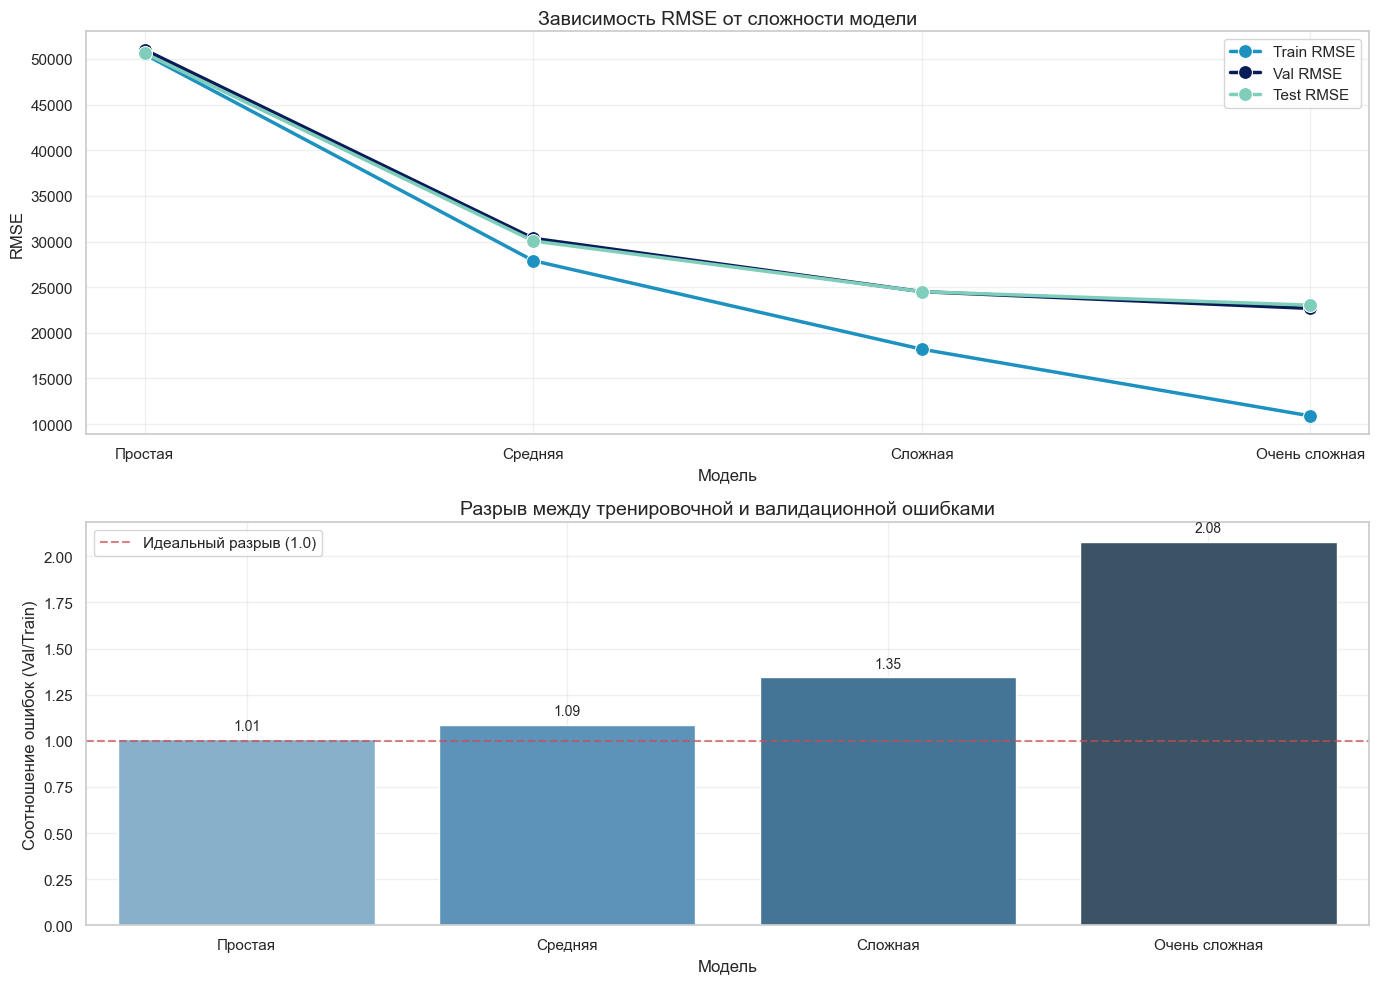


Оптимальная модель по валидационной ошибке: Очень сложная
Параметры: max_depth=9, min_child_weight=5, n_estimators=2000
Метрики: Train RMSE=10896.74, Val RMSE=22671.91, Test RMSE=23028.40, Gap=2.08

Запуск кросс-валидации для определения оптимального числа итераций...
Обучение на фолде 1/5
[0]	train-rmse:127149.98097	eval-rmse:128217.54646
[100]	train-rmse:35789.46358	eval-rmse:37014.92661
[200]	train-rmse:30531.78087	eval-rmse:32261.72604
[300]	train-rmse:27791.05761	eval-rmse:30071.14908
[400]	train-rmse:26003.02243	eval-rmse:28873.84155
[500]	train-rmse:24731.43019	eval-rmse:28138.46923
[600]	train-rmse:23777.73123	eval-rmse:27544.45527
[700]	train-rmse:22962.20850	eval-rmse:27095.88954
[800]	train-rmse:22308.76921	eval-rmse:26703.09999
[900]	train-rmse:21693.09110	eval-rmse:26394.35265
[1000]	train-rmse:21205.09075	eval-rmse:26144.69793
[1100]	train-rmse:20767.70122	eval-rmse:26005.79382
[1200]	train-rmse:20369.40923	eval-rmse:25843.02560
[1300]	train-rmse:20012.06886	eval-rmse:25

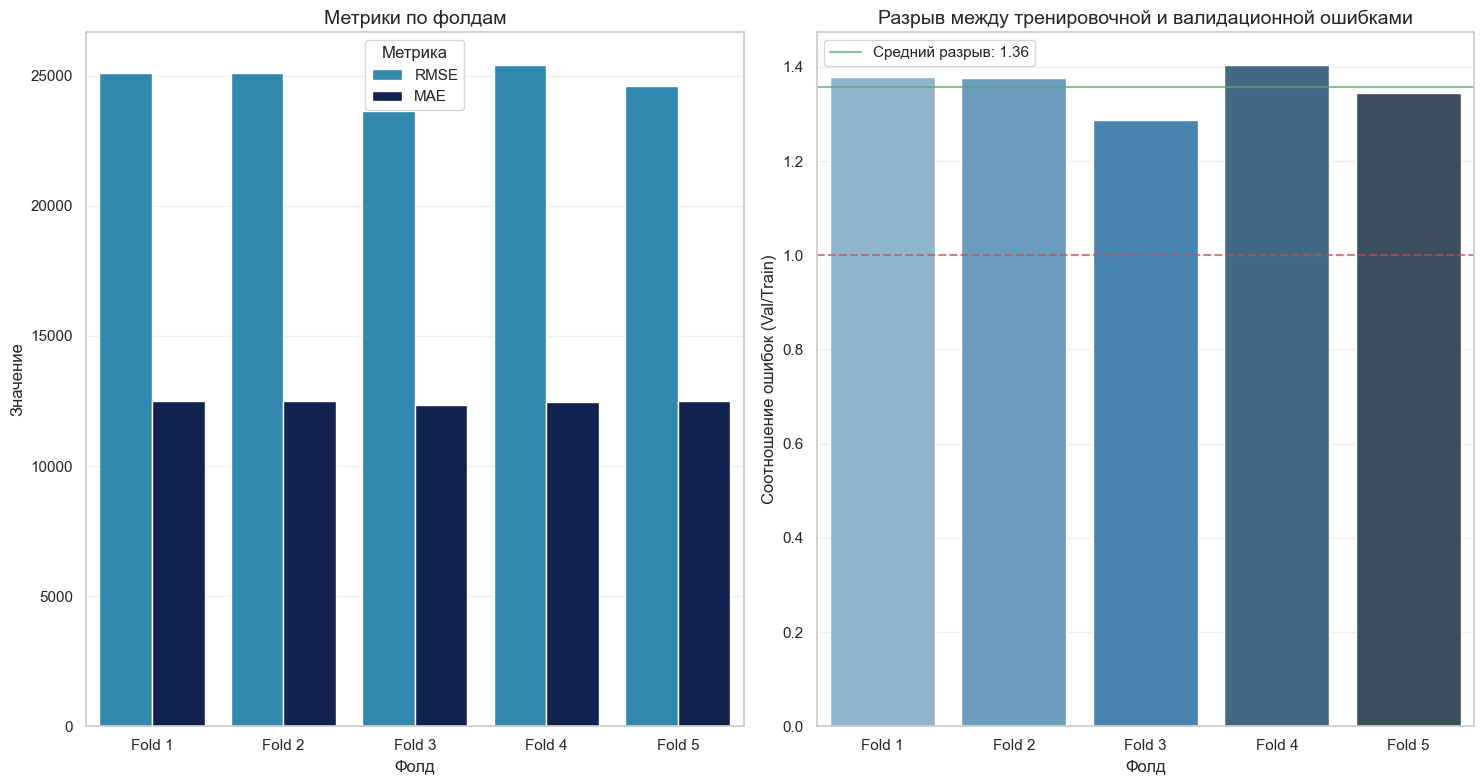

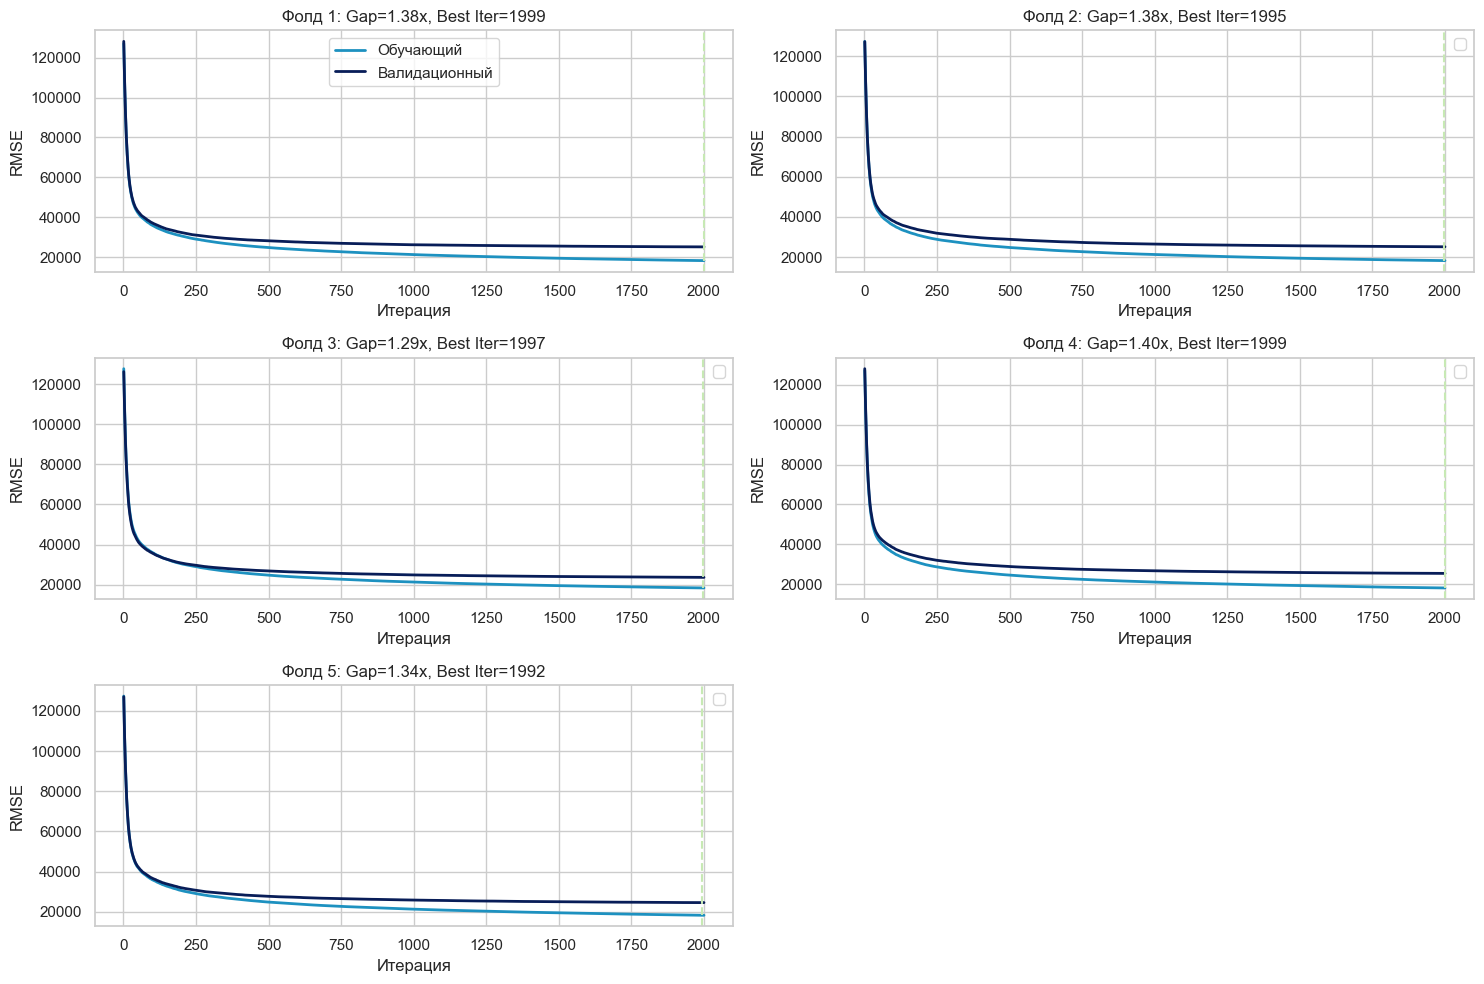


Обучение модели на всех данных для анализа кривых обучения...
[0]	train-rmse:127262.05954	eval-rmse:126757.99949
[100]	train-rmse:35660.08475	eval-rmse:37094.77035
[200]	train-rmse:30255.85971	eval-rmse:32241.86521
[300]	train-rmse:27596.55160	eval-rmse:30143.42807
[400]	train-rmse:25910.82889	eval-rmse:28880.28813
[500]	train-rmse:24716.05633	eval-rmse:28039.73164
[600]	train-rmse:23721.82606	eval-rmse:27373.16440
[700]	train-rmse:22978.23546	eval-rmse:26927.41489
[800]	train-rmse:22329.49630	eval-rmse:26522.90856
[900]	train-rmse:21740.34789	eval-rmse:26196.57002
[1000]	train-rmse:21300.17705	eval-rmse:25996.41541
[1100]	train-rmse:20856.41039	eval-rmse:25751.80371
[1200]	train-rmse:20478.52844	eval-rmse:25549.49827
[1300]	train-rmse:20141.21107	eval-rmse:25377.60828
[1400]	train-rmse:19841.93124	eval-rmse:25247.85877
[1500]	train-rmse:19549.68700	eval-rmse:25123.57623
[1600]	train-rmse:19288.52769	eval-rmse:25050.67489
[1700]	train-rmse:19041.33983	eval-rmse:24933.46334
[1800]	trai

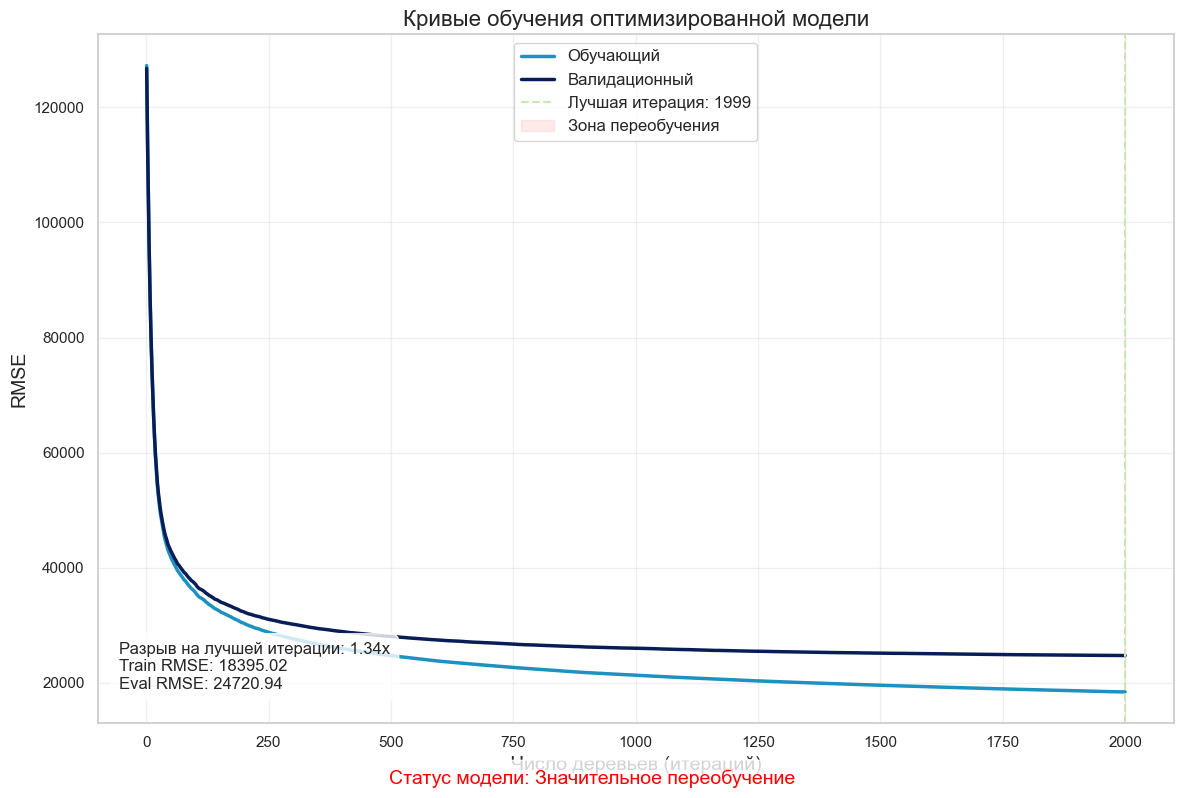


Обучение ансамбля моделей...

Обучение модели 1/5 в ансамбле
[0]	train-rmse:127732.85915	eval-rmse:126665.08851
[100]	train-rmse:35321.99891	eval-rmse:37448.49692
[200]	train-rmse:29776.64310	eval-rmse:32991.47042
[300]	train-rmse:26836.78877	eval-rmse:30916.64124
[400]	train-rmse:25003.94112	eval-rmse:29663.16625
[500]	train-rmse:23742.25197	eval-rmse:28864.00752
[600]	train-rmse:22758.77017	eval-rmse:28278.17812
[700]	train-rmse:21958.65244	eval-rmse:27797.22131
[800]	train-rmse:21251.83057	eval-rmse:27386.76900
[900]	train-rmse:20650.62832	eval-rmse:27043.77640
[1000]	train-rmse:20134.62459	eval-rmse:26782.03702
[1100]	train-rmse:19681.41292	eval-rmse:26568.37426
[1200]	train-rmse:19287.62240	eval-rmse:26394.70521
[1300]	train-rmse:18923.93731	eval-rmse:26241.63214
[1400]	train-rmse:18587.73242	eval-rmse:26111.25988
[1500]	train-rmse:18298.73809	eval-rmse:26013.56917
[1600]	train-rmse:18023.44594	eval-rmse:25918.14969
[1700]	train-rmse:17771.83017	eval-rmse:25828.52561
[1800]	train

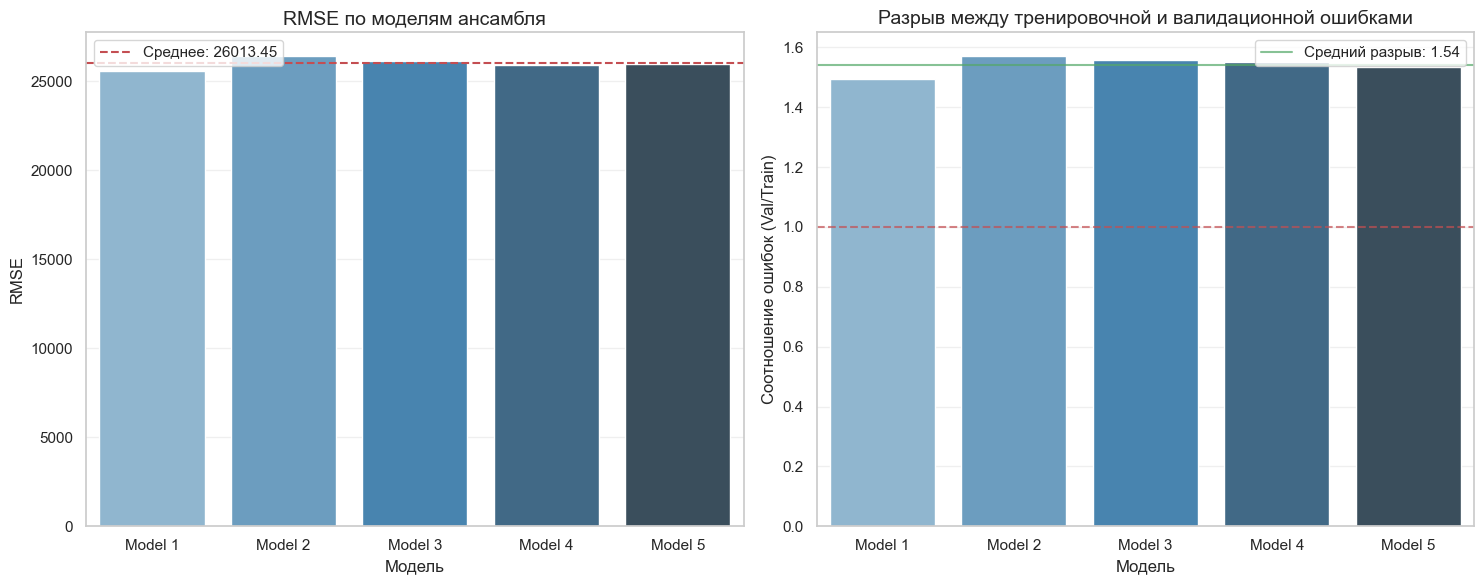

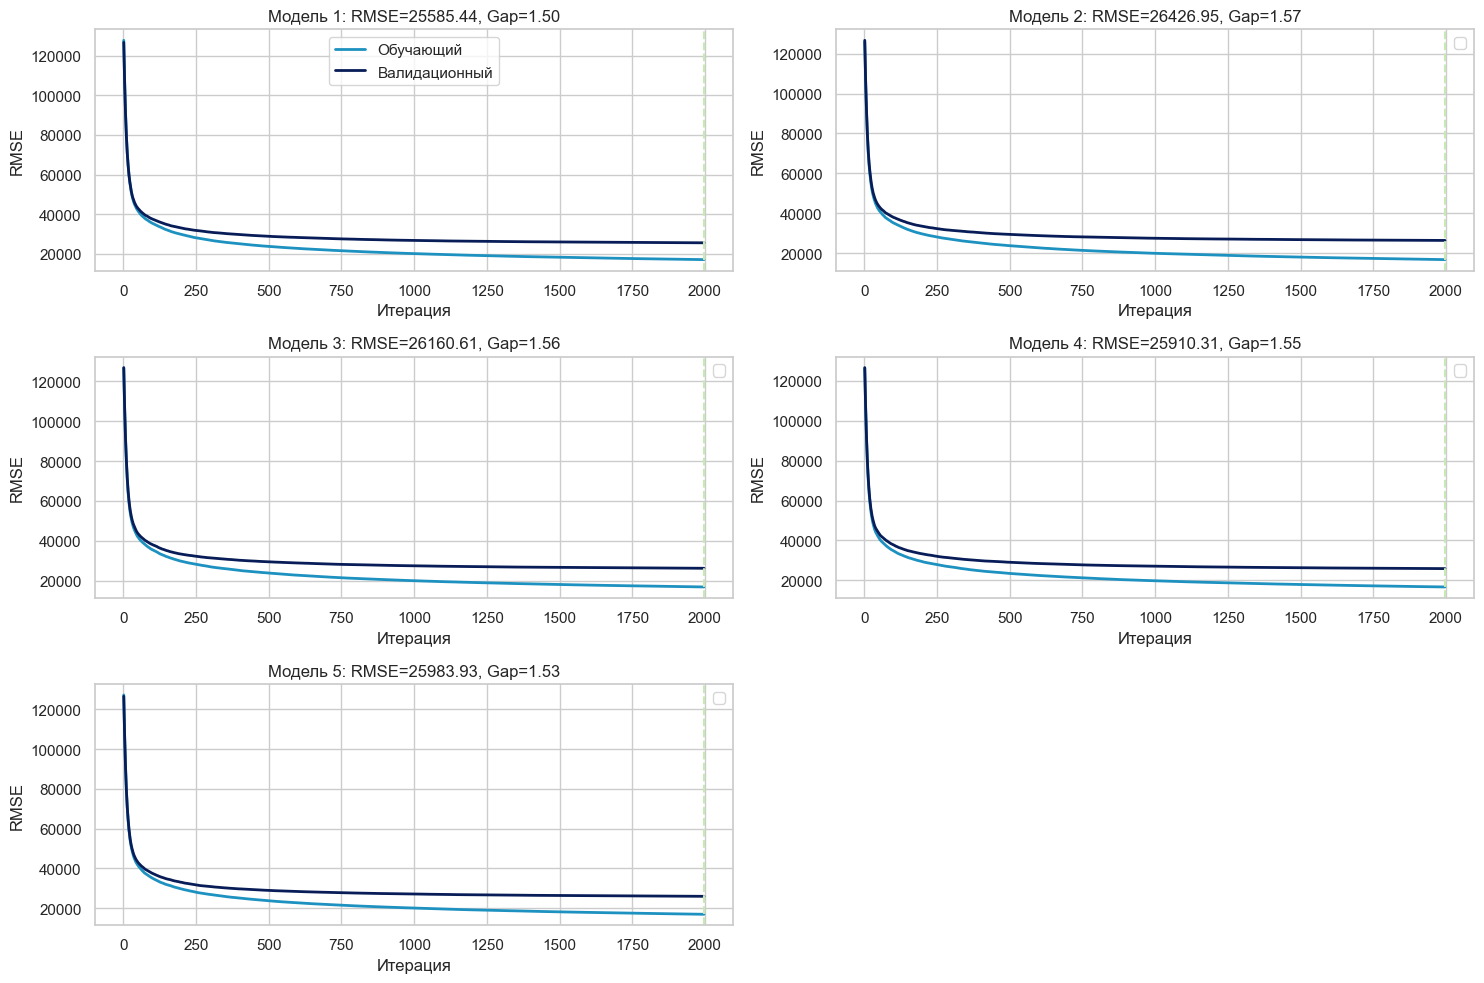


Оценка ансамбля на тестовом наборе...
Метрики ансамбля на тестовом наборе:
RMSE: 24771.8940
MAE: 12148.7557
MAPE: 0.0507%


In [ ]:
if __name__ == "__main__":
    
    df = pd.read_csv('reestr_ANALOGS.csv')
    df = df.drop(columns=['price_gradient_magnitude'])

    # Разделение признаков на категориальные и числовые
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = df.select_dtypes(exclude=['object']).columns.tolist()

    # Удаляем целевую переменную из списков признаков
    if 'price_per_sqm' in numerical_cols:
        numerical_cols.remove('price_per_sqm')

    # Разделение на признаки и целевую переменную
    X = df.drop('price_per_sqm', axis=1)
    y = df['price_per_sqm']
    
    # Запускаем оптимизацию и получаем все результаты
    all_results = run_optimized_xgboost_ensemble(X, y, n_trials=20, n_models=5)

### 2.5 Прочие построения графиков


Лучшая модель в ансамбле: модель #1 с RMSE = 25585.4396


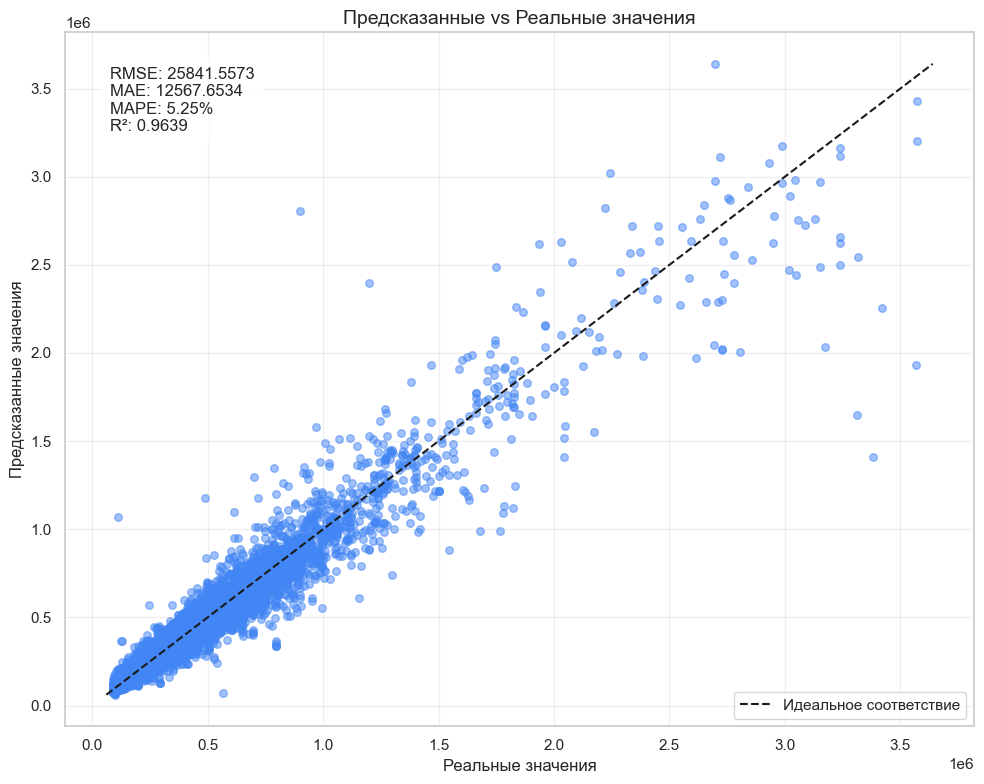

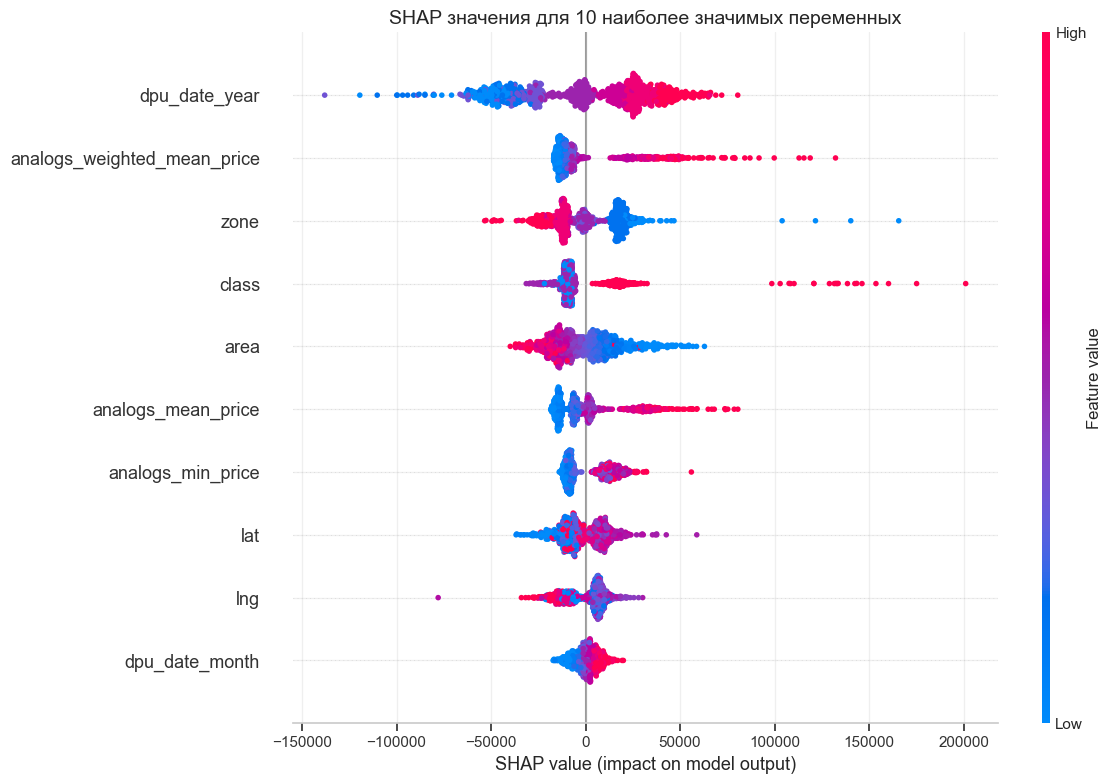

IndexError: list index out of range

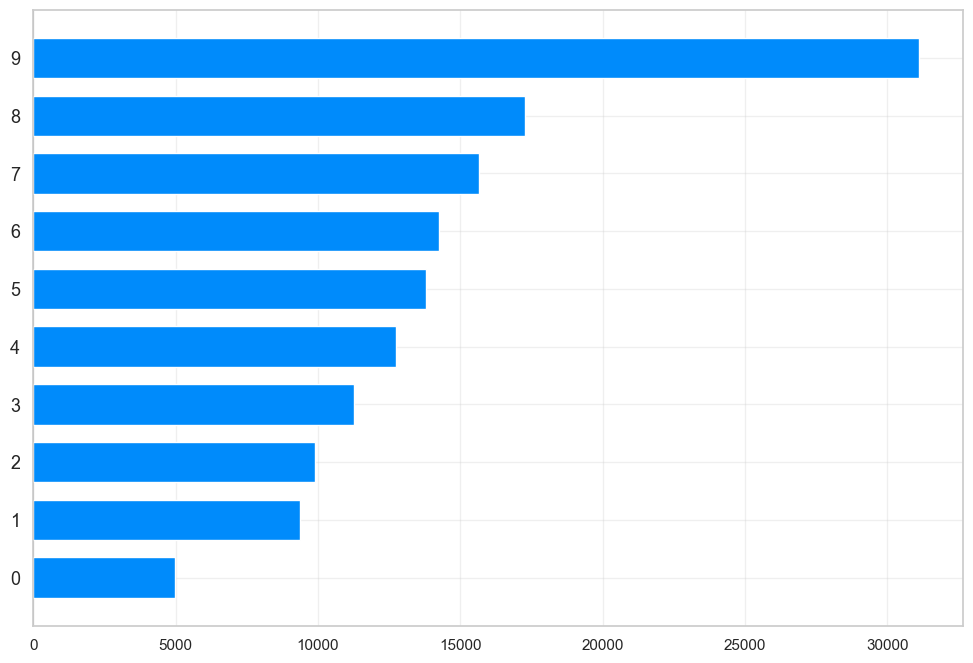

In [ ]:
# Находим лучшую модель из ансамбля
val_scores = all_results['ensemble']['val_scores']
ensemble_models = all_results['ensemble']['models']

best_model_index = np.argmin(val_scores)
best_model = ensemble_models[best_model_index]

print(f"\nЛучшая модель в ансамбле: модель #{best_model_index+1} с RMSE = {val_scores[best_model_index]:.4f}")

# Получаем данные для построения графиков
X_test = all_results['data']['X_test']
y_test = all_results['data']['y_test']

# 1. График предсказаний vs фактических значений (как на вашем примере)
dtest = xgb.DMatrix(X_test)
y_pred = best_model.predict(dtest)

# Вычисляем метрики для отображения на графике
rmse_val = rmse(y_test, y_pred)
mae_val = mae(y_test, y_pred)
mape_val = mape(y_test, y_pred) * 100 
r2 = np.corrcoef(y_test, y_pred)[0, 1] ** 2

plt.figure(figsize=(10, 8))

# Настраиваем стиль графика
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '-'

# Создаем точечный график
plt.scatter(y_test, y_pred, alpha=0.5, color='#4285F4', s=30)  # Синие точки как на вашем примере

# Добавляем диагональную линию (идеальные предсказания)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Идеальное соответствие')

# Добавляем метрики на график
plt.text(
        0.05, 0.95, 
        f'RMSE: {rmse_val:.4f}\nMAE: {mae_val:.4f}\nMAPE: {mape_val:.2f}%\nR²: {r2:.4f}',
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
        )

# Настраиваем оси и подписи
plt.title('Предсказанные vs Реальные значения', fontsize=14)
plt.xlabel('Реальные значения', fontsize=12)
plt.ylabel('Предсказанные значения', fontsize=12)

# Форматируем оси с научной нотацией
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

# Добавляем легенду
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('predictions_vs_actual.png', dpi=300)
plt.show()

# 2. SHAP графики для 10 наиболее значимых переменных
import shap

# Создаем объяснитель SHAP
explainer = shap.TreeExplainer(best_model)

# Выбираем подмножество данных для объяснения (для ускорения)
if len(X_test) > 1000:
    X_sample = X_test.sample(1000, random_state=42)
else:
    X_sample = X_test

# Вычисляем SHAP значения
shap_values = explainer.shap_values(X_sample)

# 2.1 SHAP график с точками (как на вашем первом примере)
plt.figure(figsize=(12, 8))

# Настраиваем стиль графика для соответствия вашему примеру
shap.summary_plot(
                shap_values, 
                X_sample,
                max_display=10,
                plot_size=(12, 8),
                color_bar=True,
                show=False
                )

# Настраиваем график
plt.grid(True, alpha=0.3)
plt.title('SHAP значения для 10 наиболее значимых переменных', fontsize=14)
plt.tight_layout()
plt.savefig('shap_top10_features_detailed.png', dpi=300)
plt.show()

# 2.2 SHAP график с барами (как на вашем втором примере)
plt.figure(figsize=(12, 8))

# Создаем DataFrame с абсолютными значениями SHAP для сортировки
feature_importance = pd.DataFrame({
                                'feature': X_sample.columns,
                                'importance': np.abs(shap_values).mean(0)
                                })
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

# Получаем отсортированные имена признаков
sorted_features = feature_importance['feature'].tolist()

# Создаем SHAP график с барами
shap.summary_plot(
                shap_values, 
                X_sample,
                plot_type="bar",
                max_display=10, 
                plot_size=(12, 8),
                color_bar=False,
                feature_names=sorted_features, 
                show=False  
                )

# Настраиваем график
plt.grid(True, alpha=0.3)
plt.title('SHAP: 10 наиболее значимых переменных', fontsize=14)
plt.tight_layout()
plt.savefig('shap_top10_features_bar.png', dpi=300)
plt.show()

# Сохраняем лучшую модель
best_model.save_model('best_xgboost_model.json')
print("Модель сохранена в файл 'best_xgboost_model.json'")


In [ ]:
# Сохраняем лучшую модель
best_model.save_model('best_xgboost_model.json')